# Load Library

In [1]:
import tensorflow as tf
import zipfile, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Load Dataset

In [2]:
# Upload file kaggle.json yang sudah diunduh
uploaded = files.upload()

# Pastikan file sudah terupload dengan baik
for fn in uploaded.keys():
    print('File "{name}" dengan panjang {length} bytes berhasil diupload'.format(name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
File "kaggle.json" dengan panjang 72 bytes berhasil diupload


In [3]:
# Pasang Kaggle API di collab
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Unduh dataset dan masukkan ke folder tmp/content
!kaggle datasets download -d tongpython/cat-and-dog -p /tmp/content

 95% 206M/218M [00:01<00:00, 126MB/s] 
100% 218M/218M [00:01<00:00, 141MB/s]


In [14]:
# Ekstraksi file zip
local_zip = '/tmp/content/cat-and-dog.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/hasil')
zip_ref.close()

In [15]:
# Direktori data latih dan data validasi
train_dir = '/tmp/hasil/training_set/training_set'
valid_dir = '/tmp/hasil/test_set/test_set'
classes = os.listdir(train_dir)
classes

['dogs', 'cats']

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=20,
                                    zoom_range = 0.1,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                   shear_range = 0.2,
                                   fill_mode = 'nearest')


validation_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(
        train_dir,                # direktori data latih
        target_size=(150, 150),   # mengubah resolusi seluruh gambar menjadi 180x180 piksel
        batch_size=32,             # mengatur jumlah gambar yang dimuat setiap batch selama pelatihan
        class_mode='categorical') # karena ini merupakan masalah klasifikasi lebih dari 2 kelas maka menggunakan class_mode = 'categorical'

validation_generator = validation_datagen.flow_from_directory(
        valid_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 180x180 piksel
        batch_size=32,             # mengatur jumlah gambar yang dimuat setiap batch selama pelatihan
        # karena ini merupakan masalah klasifikasi lebih dari 2 kelas maka menggunakan class_mode = 'categorical'
        class_mode='categorical')

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


# Pemodelan

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 256)       0

In [10]:
from tensorflow.keras.optimizers import Adam

# Learning rate
learning_rate = 0.0001

# Inisialisasi optimizer Adam dengan learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile model dengan optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [11]:
# Jumlah sampel dan ukuran batch
total_train_samples = 8005
total_val_samples = 2023
batch_size = 32

# Menghitung steps_per_epoch dan validation_steps
steps_per_epoch = total_train_samples // batch_size
validation_steps = total_val_samples // batch_size

print(steps_per_epoch)
print(validation_steps)

250
63


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

checkpoint_path = "proyek_akhir.h5"
ModelCheckpoint = ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    mode='min',
    save_best_only=True,
    patience=5, #5, 10, 20
    verbose=1)

class StopModelCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.92 and logs.get('val_accuracy') >= 0.92):
      print("\nAccuracy and Validation Accuracy telah sama tau melebihi 92%!\nStop Train!")
      self.model.stop_training = True

StopModel = StopModelCallback()

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[ModelCheckpoint, StopModel]
)

Epoch 1/50
250/250 [==============================] - ETA: 0s - loss: 0.6813 - accuracy: 0.5510
Epoch 1: val_loss improved from inf to 0.64379, saving model to proyek_akhir.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 82s 289ms/step - loss: 0.6813 - accuracy: 0.5510 - val_loss: 0.6438 - val_accuracy: 0.6250
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 0.6397 - accuracy: 0.6318
Epoch 2: val_loss improved from 0.64379 to 0.60822, saving model to proyek_akhir.h5
250/250 [==============================] - 71s 286ms/step - loss: 0.6397 - accuracy: 0.6318 - val_loss: 0.6082 - val_accuracy: 0.6701
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.6084 - accuracy: 0.6617
Epoch 3: val_loss improved from 0.60822 to 0.56564, saving model to proyek_akhir.h5
250/250 [==============================] - 66s 265ms/step - loss: 0.6084 - accuracy: 0.6617 - val_loss: 0.5656 - val_accuracy: 0.7247
Epoch 4/50
250/250 [==============================] - ETA: 0s - loss: 0.5900 - accuracy: 0.6863
Epoch 4: val_loss improved from 0.56564 to 0.52082, saving model to proyek_akhir.h5
250/250 [==============================] - 69s 277ms/step 

In [18]:
model.evaluate(validation_generator)

64/64 [==============================] - 4s 63ms/step - loss: 0.2326 - accuracy: 0.9209


[0.23263531923294067, 0.9209095239639282]

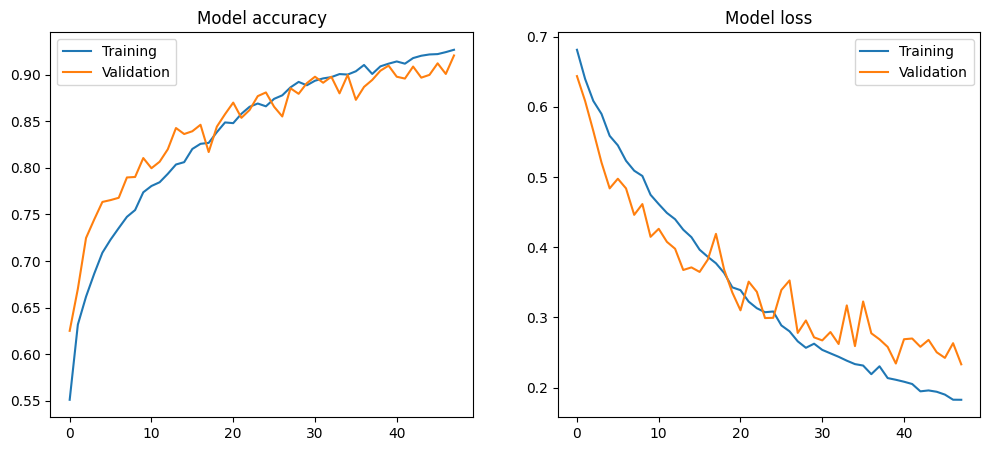

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(122)

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Model accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Model loss')

plt.show()

# Simpan Model

In [20]:
#Convert to tf lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

#save
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)